Importing Necessary Libraries & dataset

In [ ]:
!pip install statsmodels --upgrade

     |████████████████████████████████| 9.5 MB 3.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
!pip install pmdarima

     |████████████████████████████████| 1.5 MB 3.1 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import itertools
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import statsmodels.api as sm
from statsmodels.tsa import api as smt
from sklearn.neighbors import LocalOutlierFactor
import warnings 

In [ ]:
Beds = pd.read_csv('/content/Beds_Occupied.csv',index_col=False)

In [ ]:
Beds.head()

,collection_date,Total Inpatient Beds
0,15-06-2020,293
1,16-06-2020,295
2,17-06-2020,290
3,18-06-2020,291
4,19-06-2020,288


In [ ]:
Beds['Total Beds Available']=900-Beds['Total Inpatient Beds']
Beds.head()
# to get th total beds available

,collection_date,Total Inpatient Beds,Total Beds Available
0,15-06-2020,293,607
1,16-06-2020,295,605
2,17-06-2020,290,610
3,18-06-2020,291,609
4,19-06-2020,288,612


In [ ]:
Beds = Beds.drop("Total Inpatient Beds",axis=1)

# EDA

In [ ]:
Beds.collection_date = pd.to_datetime(Beds.collection_date, format= "%d-%m-%Y")
# for changing the datetime in proper format

In [ ]:
Beds.set_index('collection_date', inplace=True)

In [ ]:
Beds.index

DatetimeIndex(['2020-06-15', '2020-06-16', '2020-06-17', '2020-06-18',
               '2020-06-19', '2020-06-20', '2020-06-21', '2020-06-22',
               '2020-06-23', '2020-06-24',
               ...
               '2021-06-06', '2021-06-07', '2021-06-08', '2021-06-09',
               '2021-06-10', '2021-06-11', '2021-06-12', '2021-06-13',
               '2021-06-14', '2021-06-15'],
              dtype='datetime64[ns]', name='collection_date', length=359, freq=None)

In [ ]:
Beds.dtypes # checking data type of columns

Total Beds Available    int64
dtype: object

In [ ]:
dt = pd.date_range("06-15-2020","06-15-2021")
idx = pd.DatetimeIndex(dt)
df= Beds.reindex(idx)

In [ ]:
pd.set_option('display.max_rows', df.shape[0]+1)
print(df)

            Total Beds Available
2020-06-15                 607.0
2020-06-16                 605.0
2020-06-17                 610.0
2020-06-18                 609.0
2020-06-19                 612.0
2020-06-20                 611.0
2020-06-21                 623.0
2020-06-22                 611.0
2020-06-23                 608.0
2020-06-24                 607.0
2020-06-25                 609.0
2020-06-26                 618.0
2020-06-27                 617.0
2020-06-28                 616.0
2020-06-29                 706.0
2020-06-30                 608.0
2020-07-01                 625.0
2020-07-02                 610.0
2020-07-03                 613.0
2020-07-04                 617.0
2020-07-05                 618.0
2020-07-06                 616.0
2020-07-07                 609.0
2020-07-08                 608.0
2020-07-09                 606.0
2020-07-10                 613.0
2020-07-11                 616.0
2020-07-12                 618.0
2020-07-13                 608.0
2020-07-14

In [ ]:
#Any missing data?
print("missing_data:", df.isna().sum())
print("unique dates:", df.index.nunique())

missing_data: Total Beds Available    7
dtype: int64
unique dates: 366


In [ ]:
df =df.interpolate(method='time')

In [ ]:
#Checking missing data
print("missing_data:", df.isna().sum())
print("unique dates:", df.index.nunique())

missing_data: Total Beds Available    0
dtype: int64
unique dates: 366


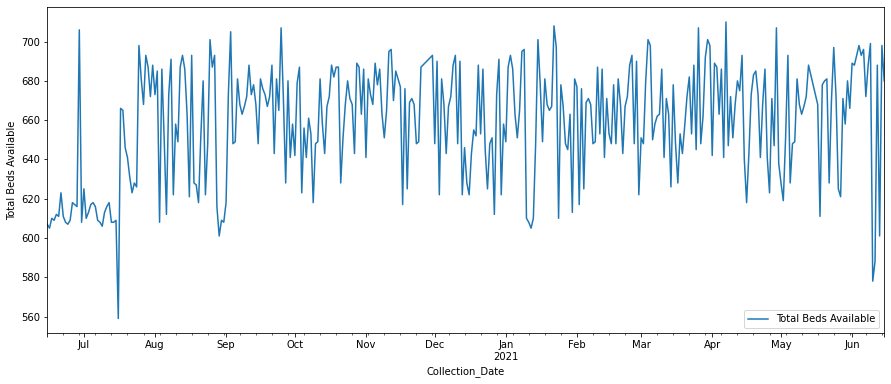

In [ ]:
# line plot of time series
ax = df.plot.line(figsize=(15, 6))
# Specify the x-axis label in your plot
ax.set_xlabel('Collection_Date')
# Specify the y-axis label in your plot
ax.set_ylabel('Total Beds Available');
# From the plot we can see that the data is stationary.

Time Series Histogram and Density Plots

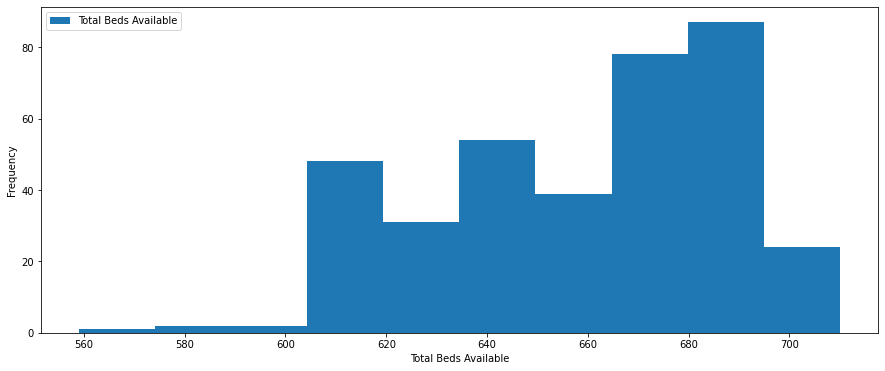

In [ ]:
# Generate a histogram
ax = df.plot(kind='hist',figsize=(15, 6),fontsize=10)

# Set the labels and display the plot
ax.set_xlabel('Total Beds Available', fontsize=10)
plt.legend(fontsize=10)
plt.show();

# from histogram we can see that the data is negatively skewed and 670 to 690 beds are empty most of the times
# There are outliers in the dataset

Text(0, 0.5, 'Density plot of filled beds')

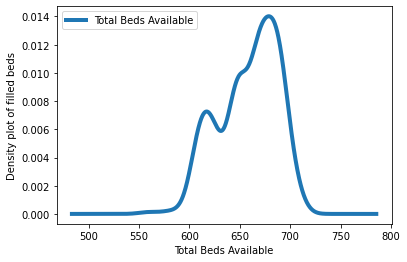

In [ ]:
# Display density plot of total inpatient bed values
ax = df.plot(kind='density', linewidth=4, fontsize=10)

# Annotate x-axis labels
ax.set_xlabel('Total Beds Available', fontsize=10)

# Annotate y-axis labels
ax.set_ylabel('Density plot of filled beds', fontsize=10)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


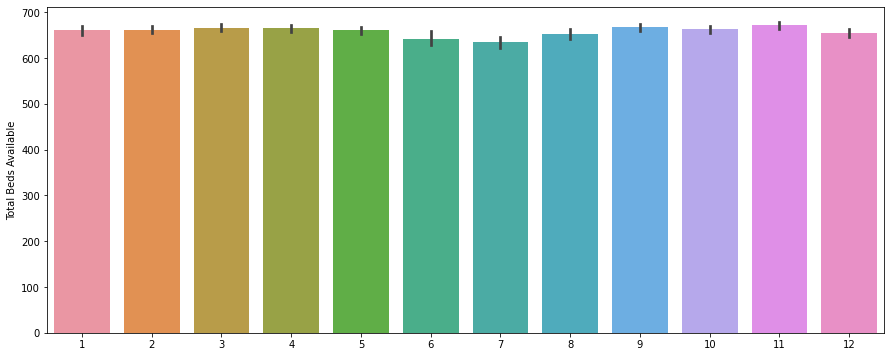

In [ ]:
fig, ax = plt.subplots(figsize=(15,6))
sns.barplot(df['Total Beds Available'].index.month, df['Total Beds Available'], ax=ax)
# checking each months total inpatient beds count on bar chart

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


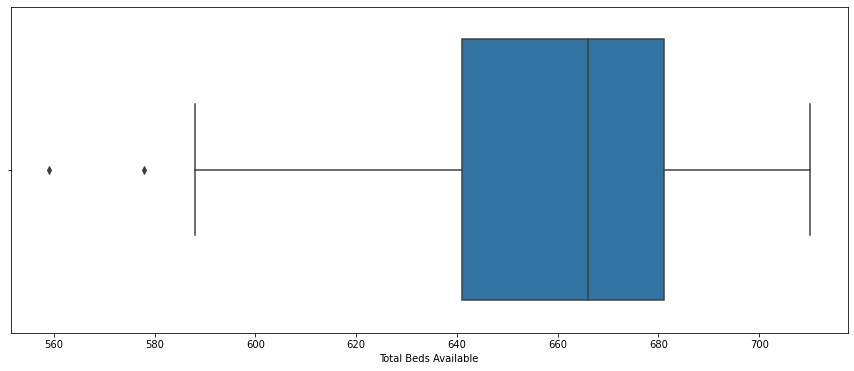

In [ ]:
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(df['Total Beds Available'], ax=ax)
# We can see that there are outliers in the dataset

Detecting Outliers and Treating them

In [ ]:
q1 = df['Total Beds Available'].quantile(0.25)
q3 = df['Total Beds Available'].quantile(0.75)
iqr = q3 - q1

In [ ]:
low = q1-1.5*iqr
high = q3+1.5*iqr
print("Outliers = ",df.loc[(df['Total Beds Available'] < low) | (df['Total Beds Available'] > high), 'Total Beds Available'])

Outliers =  2020-07-16    559.0
2021-06-10    578.0
Freq: 329D, Name: Total Beds Available, dtype: float64


In [ ]:
df['Total Beds Available'] = np.where(df['Total Beds Available']>high, high,
                                      np.where(df['Total Beds Available']<low, low, df['Total Beds Available']))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


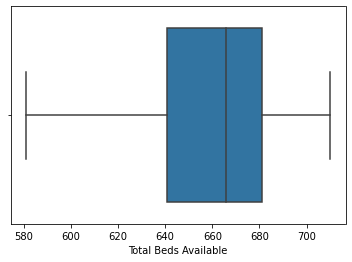

In [ ]:
fig, ax = plt.subplots()
sns.boxplot(df['Total Beds Available'], ax=ax)

In [ ]:
df.describe()

,Total Beds Available
count,366.000000
mean,658.598361
std,28.700015
min,581.000000
25%,641.000000
50%,666.000000
75%,681.000000
max,710.000000


Decomposing using statsmodel:

We can use statsmodels to perform a decomposition of this time series.
The decomposition of time series is a statistical task that deconstructs a time series into several components, each representing one of the underlying categories of patterns.
With statsmodels we will be able to see the trend, seasonal, and residual components of our data.

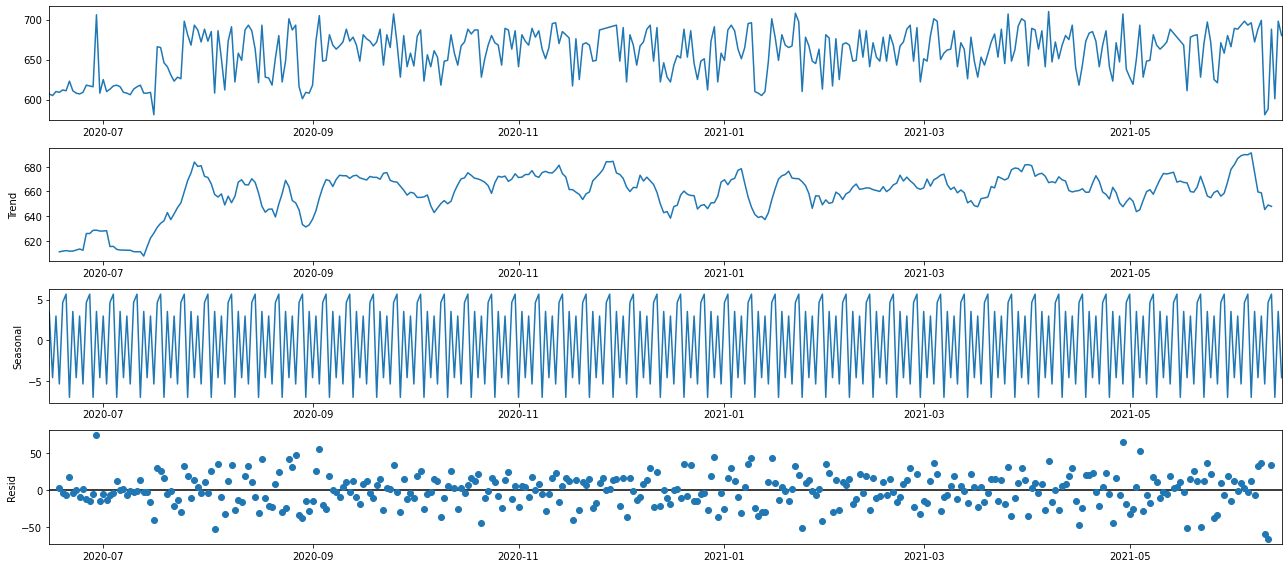

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df, model='Additive')
fig = decomposition.plot()
plt.show()
# we can see that the series is stationary

# Stationarity check

In [ ]:
from statsmodels.tsa.stattools import adfuller 

In [ ]:
df_series = df.squeeze()

In [ ]:
type(df_series)

pandas.core.series.Series

In [ ]:
adfuller(df_series)  

(-5.826977184256749,
 4.057800889565874e-07,
 4,
 361,
 {'1%': -3.4485948978753314,
  '10%': -2.571053050314224,
  '5%': -2.86957971128312},
 3263.4241804971225)

In [ ]:

adfuller_results = pd.Series(adfuller(df_series)[:4],index=['T stats','p-value','lags used','Number of observations'])
for key,value in adfuller(df_series)[4].items():
    adfuller_results['Critical Value'+' '+ key] = value
print(adfuller_results)

T stats                  -5.826977e+00
p-value                   4.057801e-07
lags used                 4.000000e+00
Number of observations    3.610000e+02
Critical Value 1%        -3.448595e+00
Critical Value 5%        -2.869580e+00
Critical Value 10%       -2.571053e+00
dtype: float64


In [ ]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

as the p-value is less than 0.05 we can say that series is stationary

Rolling mean method & ACF & PACF plot

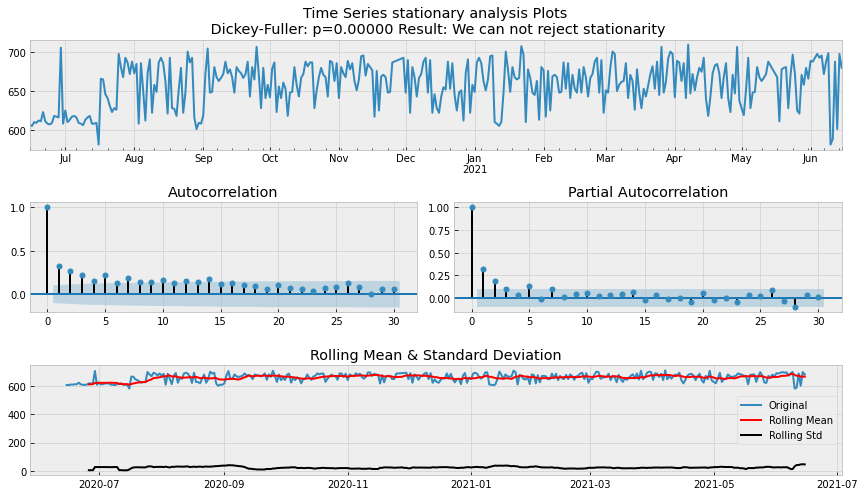

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=(12, 7))
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        mean_std_ax = plt.subplot2grid(layout, (2, 0), colspan=2)
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        hypothesis_result = "We can not reject stationarity" if p_value <= 0.05 else "We reject stationarity"
        ts_ax.set_title(
            'Time Series stationary analysis Plots\n Dickey-Fuller: p={0:.5f} Result: {1}'.format(p_value, hypothesis_result))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

        rolmean = df['Total Beds Available'].rolling(window=12).mean()
        rolstd = df['Total Beds Available'].rolling(window=12).std()

        # Plot rolling statistics:
        orig = plt.plot(df['Total Beds Available'], label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label='Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')


tsplot(df['Total Beds Available'], lags=30)

# MODEL BUILDING

In [ ]:
df.shape

(366, 1)

In [ ]:
train = df.head(336)
test = df.tail(30)

In [ ]:
train.head()

,Total Beds Available
2020-06-15,607.0
2020-06-16,605.0
2020-06-17,610.0
2020-06-18,609.0
2020-06-19,612.0


In [ ]:

from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
def RMSE(pred,org):
    temp = np.sqrt(mean_squared_error(org, pred))
    return np.mean(temp)

Naive Model

In [ ]:
dd= np.asarray(train['Total Beds Available'])
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]

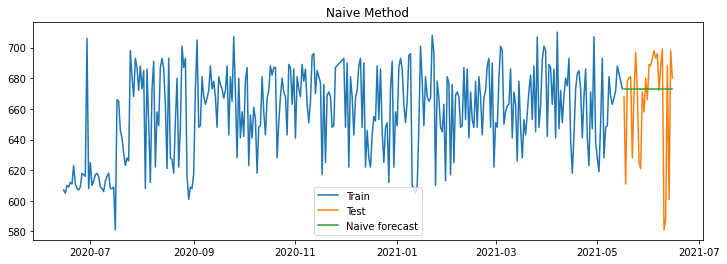

In [ ]:
#Plot train, test and forecast
plt.figure(figsize=(12,4))
plt.plot(train['Total Beds Available'], label='Train')
plt.plot(test['Total Beds Available'], label='Test')
plt.plot(y_hat['naive'], label='Naive forecast')
plt.legend(loc='best')
plt.title('Naive Method')
plt.show()

In [ ]:
#RMSE Value
RMSE_Naive=RMSE(y_hat['naive'],test['Total Beds Available'])

In [ ]:
RMSE_Naive

35.14825742479988

Simple Average Method

In [ ]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Total Beds Available'].mean()

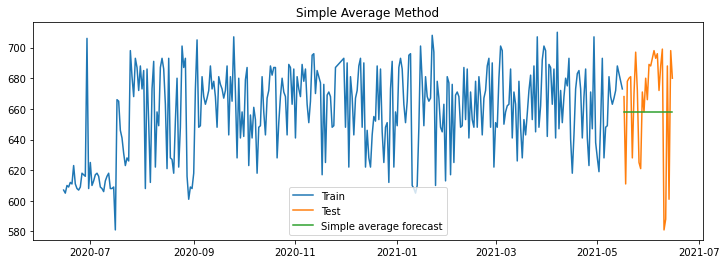

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(train['Total Beds Available'], label='Train')
plt.plot(test['Total Beds Available'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Simple average forecast')
plt.legend(loc='best')
plt.title('Simple Average Method')
plt.show()

In [ ]:
#RMSE Value
RMSE_Simpleavg=RMSE(y_hat_avg['avg_forecast'],test['Total Beds Available'])

In [ ]:
RMSE_Simpleavg

35.0479208354712

MOVING AVERAGE

In [ ]:
y_hat_sma = test.copy()
y_hat_sma['moving_avg_forecast'] = train['Total Beds Available'].rolling(12).mean().iloc[-1]

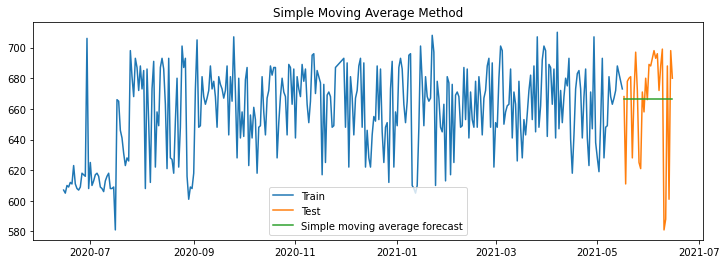

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(train['Total Beds Available'], label='Train')
plt.plot(test['Total Beds Available'], label='Test')
plt.plot(y_hat_sma['moving_avg_forecast'], label='Simple moving average forecast')
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

In [ ]:
#RMSE Value
RMSE_SimpleMovingAvg=RMSE(y_hat_sma['moving_avg_forecast'],test['Total Beds Available'])

In [ ]:
RMSE_SimpleMovingAvg

34.309133866459916

Simple Exponential Smoothing

In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [ ]:
y_hat_ses = test.copy()
fit2 = SimpleExpSmoothing(np.asarray(train['Total Beds Available'])).fit(smoothing_level=0.6,optimized=False)
y_hat_ses['SES'] = fit2.forecast(len(test))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


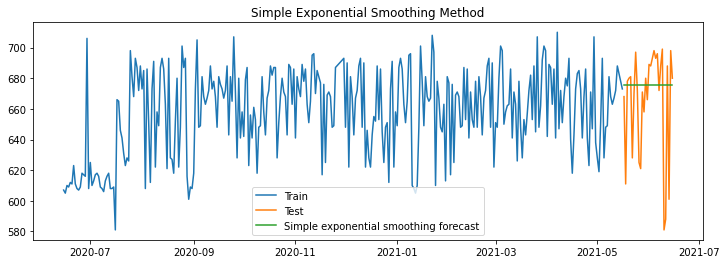

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(train['Total Beds Available'], label='Train')
plt.plot(test['Total Beds Available'], label='Test')
plt.plot(y_hat_ses['SES'], label='Simple exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing Method')
plt.show()

In [ ]:
#RMSE Value
RMSE_Exponentialsmoothing=RMSE(y_hat_ses['SES'],test['Total Beds Available'])

In [ ]:
RMSE_Exponentialsmoothing

35.82497299189456

Holts Linear Trend method

In [ ]:
y_hat_holt = test.copy()
fit1 = Holt(np.asarray(train['Total Beds Available'])).fit(smoothing_level = 0.02,smoothing_slope = 0.1)
y_hat_holt['Holt_linear'] = fit1.forecast(len(test))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  


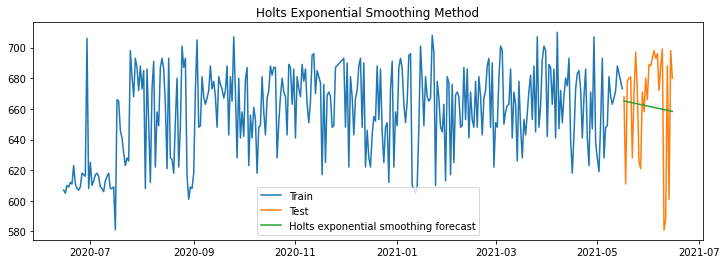

In [ ]:
plt.figure(figsize=(12,4))
plt.plot( train['Total Beds Available'], label='Train')
plt.plot(test['Total Beds Available'], label='Test')
plt.plot(y_hat_holt['Holt_linear'], label='Holts exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Holts Exponential Smoothing Method')
plt.show()

In [ ]:
#RMSE Value
RMSE_HoltLinear= RMSE(y_hat_holt['Holt_linear'],test['Total Beds Available'])

In [ ]:
RMSE_HoltLinear

34.56342850913107

Holt's Winter Exponential Smoothing with Additive seasonality and Additive trend

In [ ]:
y_hat_hwa = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['Total Beds Available']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
y_hat_hwa['Holt_Winter'] = fit1.forecast(len(test))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


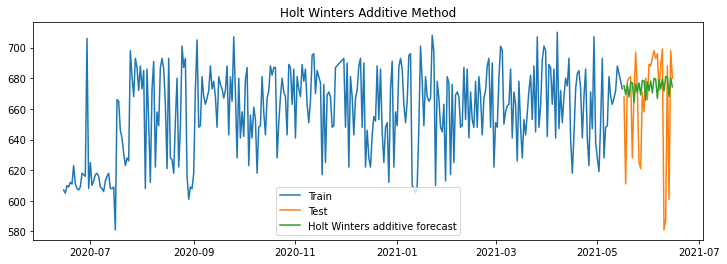

In [ ]:
plt.figure(figsize=(12,4))
plt.plot( train['Total Beds Available'], label='Train')
plt.plot(test['Total Beds Available'], label='Test')
plt.plot(y_hat_hwa['Holt_Winter'], label='Holt Winters additive forecast')
plt.legend(loc='best')
plt.title('Holt Winters Additive Method')
plt.show()

In [ ]:
#RMSE Value
RMSE_HoltWinterAdd=RMSE(y_hat_hwa['Holt_Winter'],test['Total Beds Available'])

In [ ]:
RMSE_HoltWinterAdd

35.11867728243179

Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [ ]:
y_hat_hwm = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['Total Beds Available']) ,seasonal_periods=7 ,trend='add', seasonal='mul',).fit()
y_hat_hwm['Holt_Winter'] = fit1.forecast(len(test))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


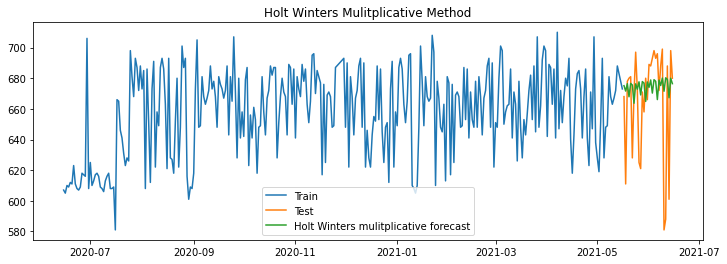

In [ ]:
plt.figure(figsize=(12,4))
plt.plot( train['Total Beds Available'], label='Train')
plt.plot(test['Total Beds Available'], label='Test')
plt.plot(y_hat_hwm['Holt_Winter'], label='Holt Winters mulitplicative forecast')
plt.legend(loc='best')
plt.title('Holt Winters Mulitplicative Method')
plt.show()

In [ ]:
#RMSE Value
RMSE_HoltwinterMult=RMSE(y_hat_hwm['Holt_Winter'],test['Total Beds Available'])

In [ ]:
RMSE_HoltwinterMult

35.04374034743399

AR Model

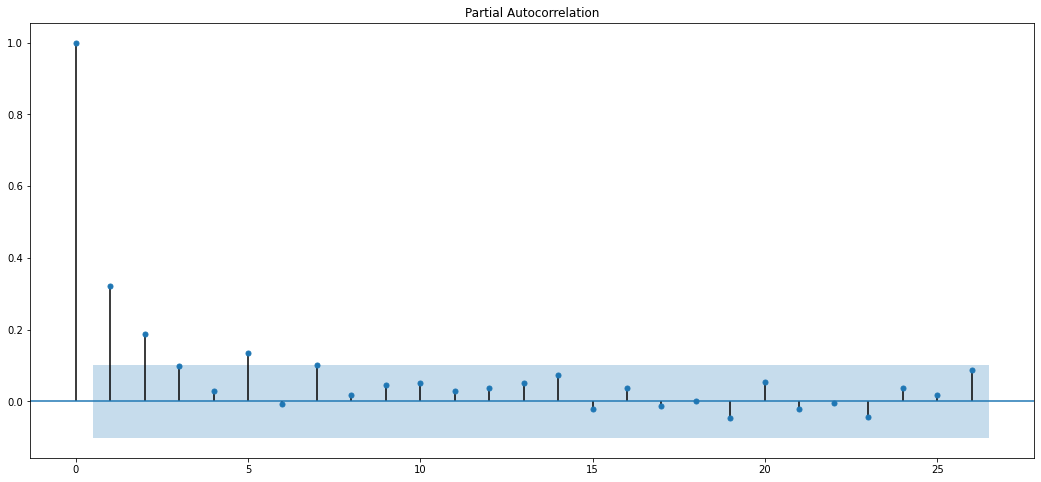

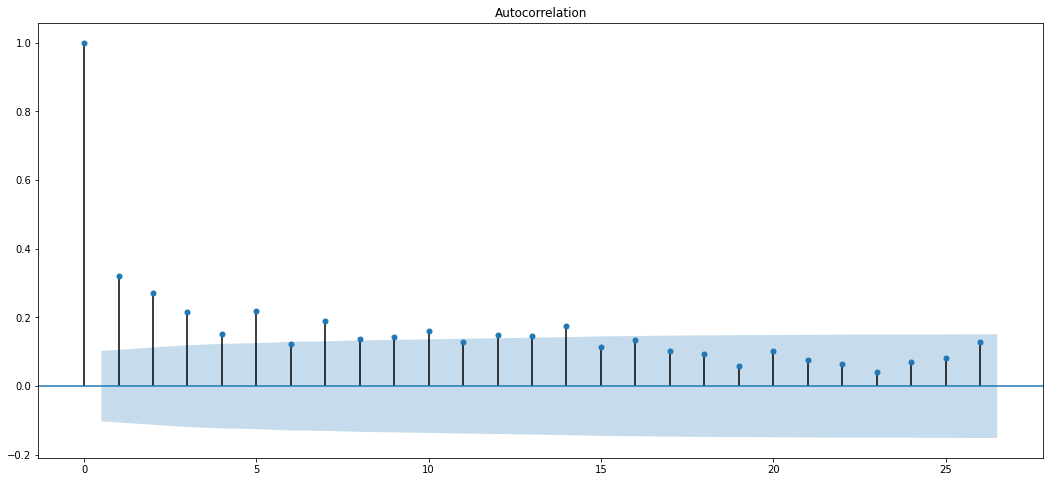

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
pacf = plot_pacf(df['Total Beds Available'])
acf = plot_acf(df['Total Beds Available'])

In [ ]:
from statsmodels.tsa.ar_model import AutoReg

In [ ]:
AR_model = AutoReg(train, lags=3).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


In [ ]:
print(AR_model.summary())

                             AutoReg Model Results                              
Dep. Variable:     Total Beds Available   No. Observations:                  336
Model:                       AutoReg(3)   Log Likelihood               -1550.026
Method:                 Conditional MLE   S.D. of innovations             25.427
Date:                  Thu, 02 Sep 2021   AIC                              6.502
Time:                          19:19:16   BIC                              6.559
Sample:                      06-18-2020   HQIC                             6.524
                           - 05-16-2021                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
intercept                 316.5166     44.065      7.183      0.000     230.152     402.881
Total Beds Available.L1     0.2393      0.054      4.392      0.000       0.

In [ ]:
y_hat_ar = AR_model.predict(start = test.index[0],end = test.index[-1],dynamic= False)

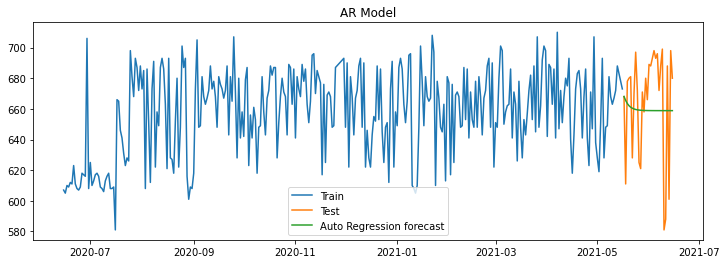

In [ ]:
plt.figure(figsize=(12,4))
plt.plot( train['Total Beds Available'], label='Train')
plt.plot(test['Total Beds Available'], label='Test')
plt.plot(y_hat_ar, label='Auto Regression forecast')
plt.legend(loc='best')
plt.title('AR Model')
plt.show()

In [ ]:
#RMSE Value
RMSE_AR= RMSE(y_hat_ar,test['Total Beds Available'])

In [ ]:
RMSE_AR

35.004775741164536

MA Model

In [ ]:
from statsmodels.tsa.arima_model import ARMA
from random import random

In [ ]:
# fit model
MA_model = ARMA(train, order=(0, 5)).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [ ]:
print(MA_model.summary())

                               ARMA Model Results                               
Dep. Variable:     Total Beds Available   No. Observations:                  336
Model:                       ARMA(0, 5)   Log Likelihood               -1565.593
Method:                         css-mle   S.D. of innovations             25.539
Date:                  Thu, 02 Sep 2021   AIC                           3145.186
Time:                          19:19:17   BIC                           3171.906
Sample:                      06-15-2020   HQIC                          3155.837
                           - 05-16-2021                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                        657.8860      2.562    256.750      0.000     652.864     662.908
ma.L1.Total Beds Available     0.2665      0.055      4.839      0.

In [ ]:
y_hat_ma = MA_model.predict(start = test.index[0],end = test.index[-1],dynamic= False)

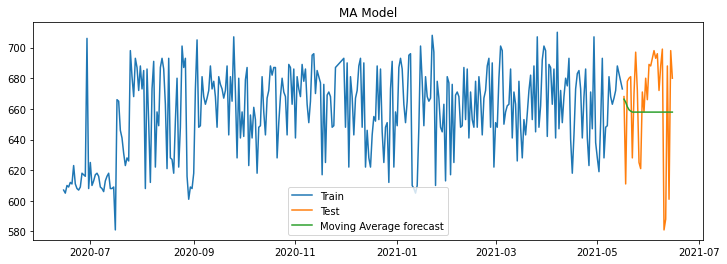

In [ ]:
plt.figure(figsize=(12,4))
plt.plot( train['Total Beds Available'], label='Train')
plt.plot(test['Total Beds Available'], label='Test')
plt.plot(y_hat_ma, label='Moving Average forecast')
plt.legend(loc='best')
plt.title('MA Model')
plt.show()

In [ ]:
#RMSE Value
RMSE_MA=RMSE(y_hat_ma,test['Total Beds Available'])

In [ ]:
RMSE_MA

35.227566887647036

ARMA Model

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
ARMA_model = ARIMA(train['Total Beds Available'],order=(1,0,1)).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [ ]:
print(ARMA_model.summary())

                               ARMA Model Results                               
Dep. Variable:     Total Beds Available   No. Observations:                  336
Model:                       ARMA(1, 1)   Log Likelihood               -1560.891
Method:                         css-mle   S.D. of innovations             25.169
Date:                  Thu, 02 Sep 2021   AIC                           3129.782
Time:                          19:19:17   BIC                           3145.050
Sample:                      06-15-2020   HQIC                          3135.868
                           - 05-16-2021                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                        656.2198      6.634     98.921      0.000     643.218     669.222
ar.L1.Total Beds Available     0.9609      0.034     28.241      0.

In [ ]:
y_hat_arma = ARMA_model.predict(start = test.index[0],end = test.index[-1],typ='levels')
print(y_hat_arma)

2021-05-17    669.090796
2021-05-18    668.587383
2021-05-19    668.103660
2021-05-20    667.638856
2021-05-21    667.192231
2021-05-22    666.763075
2021-05-23    666.350705
2021-05-24    665.954463
2021-05-25    665.573719
2021-05-26    665.207867
2021-05-27    664.856325
2021-05-28    664.518531
2021-05-29    664.193950
2021-05-30    663.882064
2021-05-31    663.582377
2021-06-01    663.294411
2021-06-02    663.017708
2021-06-03    662.751828
2021-06-04    662.496346
2021-06-05    662.250858
2021-06-06    662.014970
2021-06-07    661.788309
2021-06-08    661.570514
2021-06-09    661.361236
2021-06-10    661.160145
2021-06-11    660.966918
2021-06-12    660.781249
2021-06-13    660.602841
2021-06-14    660.431412
2021-06-15    660.266688
Freq: D, dtype: float64


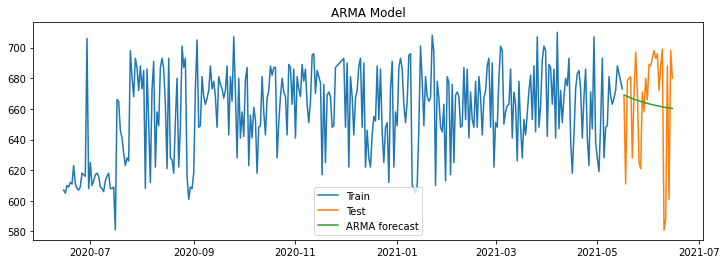

In [ ]:
plt.figure(figsize=(12,4))
plt.plot( train['Total Beds Available'], label='Train')
plt.plot(test['Total Beds Available'], label='Test')
plt.plot(y_hat_arma, label='ARMA forecast')
plt.legend(loc='best')
plt.title('ARMA Model')
plt.show()

In [ ]:
#RMSE Value
RMSE_ARMA=RMSE(y_hat_arma,test['Total Beds Available'])

In [ ]:
RMSE_ARMA

34.53995712327207

ARIMA Model

In [ ]:
from pmdarima import auto_arima
warnings.filterwarnings("ignore")

In [ ]:
stepwise_fit= auto_arima(df['Total Beds Available'], trace= True,
                         suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3599.065, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3511.505, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3429.062, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3597.078, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3425.190, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3425.161, Time=0.33 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3486.055, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3427.104, Time=0.46 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3429.714, Time=0.34 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3478.249, Time=0.22 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3426.401, Time=1.15 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3424.664, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3424.512, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  366
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1709.256
Date:                Thu, 02 Sep 2021   AIC                           3424.512
Time:                        19:19:24   BIC                           3436.211
Sample:                             0   HQIC                          3429.161
                                - 366                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1384      0.048      2.885      0.004       0.044       0.232
ma.L1         -0.9226      0.019    -47.540      0.000      -0.961      -0.885
sigma2       680.8596     47.947     14.200      0.000     586.885     774.834
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                12.75
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                            -0.40
Prob(H) (two-sided):                  0.99   Kurtosis:                         3.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
ARIMA_model = ARIMA(train['Total Beds Available'],order=(1,1,1)).fit()

In [ ]:
print(ARIMA_model.summary())

                               ARIMA Model Results                                
Dep. Variable:     D.Total Beds Available   No. Observations:                  335
Model:                     ARIMA(1, 1, 1)   Log Likelihood               -1555.301
Method:                           css-mle   S.D. of innovations             25.062
Date:                    Thu, 02 Sep 2021   AIC                           3118.602
Time:                            19:19:24   BIC                           3133.858
Sample:                        06-16-2020   HQIC                          3124.684
                             - 05-16-2021                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            0.1594      0.135      1.180      0.238      -0.105       0.424
ar.L1.D.Total Beds Available     0.1337      

In [ ]:
y_hat_arima = ARIMA_model.predict(start = test.index[0],end = test.index[-1],typ='levels')
print(y_hat_arima)

2021-05-17    668.789566
2021-05-18    668.364808
2021-05-19    668.446143
2021-05-20    668.595136
2021-05-21    668.753174
2021-05-22    668.912422
2021-05-23    669.071830
2021-05-24    669.231261
2021-05-25    669.390694
2021-05-26    669.550128
2021-05-27    669.709562
2021-05-28    669.868995
2021-05-29    670.028429
2021-05-30    670.187863
2021-05-31    670.347297
2021-06-01    670.506730
2021-06-02    670.666164
2021-06-03    670.825598
2021-06-04    670.985032
2021-06-05    671.144466
2021-06-06    671.303899
2021-06-07    671.463333
2021-06-08    671.622767
2021-06-09    671.782201
2021-06-10    671.941634
2021-06-11    672.101068
2021-06-12    672.260502
2021-06-13    672.419936
2021-06-14    672.579369
2021-06-15    672.738803
Freq: D, dtype: float64


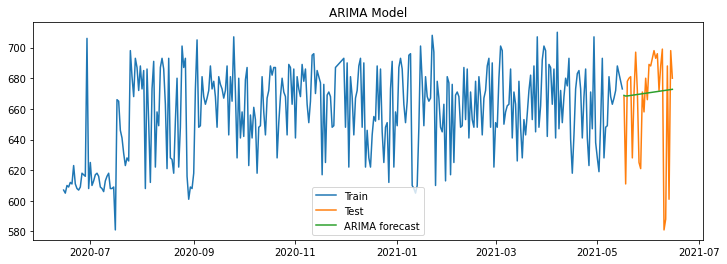

In [ ]:
plt.figure(figsize=(12,4))
plt.plot( train['Total Beds Available'], label='Train')
plt.plot(test['Total Beds Available'], label='Test')
plt.plot(y_hat_arima, label='ARIMA forecast')
plt.legend(loc='best')
plt.title('ARIMA Model')
plt.show()

In [ ]:
#RMSE Value
RMSE_ARIMA=RMSE(y_hat_arima,test['Total Beds Available'])

In [ ]:
RMSE_ARIMA

34.68209949408536

SARIMA

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

In [ ]:
# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [ ]:
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None
for param in pdq:   
    for param_seasonal in seasonal_pdq: 
        temp_model = SARIMAX(train,order=param,seasonal_order = param_seasonal,enforce_invertibility=False,
                             enforce_stationarity=False)
        results = temp_model.fit(disp=False)
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
            best_seasonal_pdq = param_seasonal
print("Best ARIMA {} x {} model - AIC:{}".format(best_pdq,best_seasonal_pdq,best_aic))

Best ARIMA (1, 1, 1) x (0, 1, 1, 12) model - AIC:2913.7157754862137


In [ ]:
SARIMA_model = SARIMAX(train,order=(0,1,1),seasonal_order=(0,1,1,12),enforce_invertibility=False,
                             enforce_stationarity=False).fit()

In [ ]:
y_hat_sarima = SARIMA_model.predict(start = test.index[0],end = test.index[-1], dynamic=False)

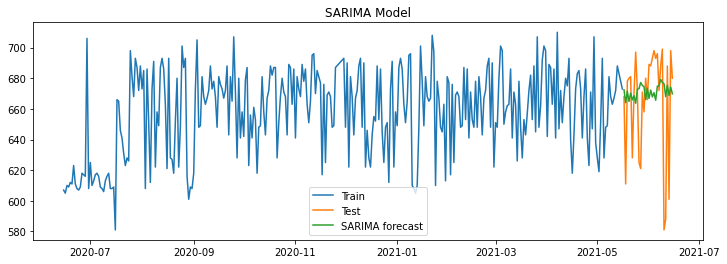

In [ ]:
plt.figure(figsize=(12,4))
plt.plot( train['Total Beds Available'], label='Train')
plt.plot(test['Total Beds Available'], label='Test')
plt.plot(y_hat_sarima, label='SARIMA forecast')
plt.legend(loc='best')
plt.title('SARIMA Model')
plt.show()

In [ ]:
#RMSE Value
RMSE_SARIMA=RMSE(y_hat_sarima,test['Total Beds Available'])

In [ ]:
RMSE_SARIMA

34.92042535562385

FB Prophet

In [ ]:
train.head()

,Total Beds Available
2020-06-15,607.0
2020-06-16,605.0
2020-06-17,610.0
2020-06-18,609.0
2020-06-19,612.0


In [ ]:
train_prophet = pd.DataFrame()
train_prophet['ds'] = train.index
train_prophet['y'] = train['Total Beds Available'].values

In [ ]:
train_prophet.tail()

,ds,y
331,2021-05-12,672.0
332,2021-05-13,688.0
333,2021-05-14,683.0
334,2021-05-15,678.0
335,2021-05-16,673.0


In [ ]:
from fbprophet import Prophet

In [ ]:
prophet_model = Prophet(interval_width=0.95, daily_seasonality=True)
prophet_model.fit(train_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [ ]:
future = prophet_model.make_future_dataframe(periods=30,freq='D')
future.tail()

,ds
361,2021-06-11
362,2021-06-12
363,2021-06-13
364,2021-06-14
365,2021-06-15


In [ ]:
Profet_forecast = prophet_model.predict(future)
Profet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
361,2021-06-11,669.379080,622.358983,716.768126
362,2021-06-12,669.948826,623.974166,720.748548
363,2021-06-13,656.057159,607.587760,703.163711
364,2021-06-14,666.941825,619.912654,710.602812
365,2021-06-15,659.007860,608.167069,704.594199


In [ ]:
Profet_forecast = Profet_forecast.set_index('ds')

In [ ]:
y_hat_profet = Profet_forecast.tail(30)

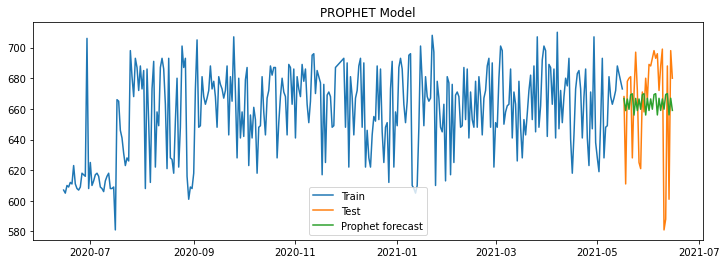

In [ ]:
plt.figure(figsize=(12,4))
plt.plot( train['Total Beds Available'], label='Train')
plt.plot(test['Total Beds Available'], label='Test')
plt.plot(y_hat_profet['yhat'], label='Prophet forecast')
plt.legend(loc='best')
plt.title('PROPHET Model')
plt.show()

In [ ]:
#RMSE Value
RMSE_Profet = RMSE(y_hat_profet['yhat'],test['Total Beds Available'])

In [ ]:
RMSE_Profet

34.10238397539026

Comparing the results

In [ ]:
data = {"MODEL":pd.Series(["RMSE_Naive","RMSE_Simpleavg","RMSE_SimpleMovingAvg","RMSE_Exponentialsmoothing","RMSE_HoltLinear","RMSE_HoltWinterAdd","RMSE_HoltwinterMult","RMSE_AR","RMSE_MA","RMSE_ARMA","RMSE_ARIMA","RMSE_SARIMA","RMSE_Profet"]),"RMSE_Values":pd.Series([RMSE_Naive, RMSE_Simpleavg, RMSE_SimpleMovingAvg, RMSE_Exponentialsmoothing, RMSE_HoltLinear, RMSE_HoltWinterAdd, RMSE_HoltwinterMult ,RMSE_AR, RMSE_MA ,RMSE_ARMA, RMSE_ARIMA, RMSE_SARIMA, RMSE_Profet])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values
12,RMSE_Profet,34.102384
2,RMSE_SimpleMovingAvg,34.309134
9,RMSE_ARMA,34.539957
4,RMSE_HoltLinear,34.563429
10,RMSE_ARIMA,34.682099
11,RMSE_SARIMA,34.920425
7,RMSE_AR,35.004776
6,RMSE_HoltwinterMult,35.043740
1,RMSE_Simpleavg,35.047921
5,RMSE_HoltWinterAdd,35.118677


# Future Prediction

Prophet

In [ ]:
df.head()

,Total Beds Available
2020-06-15,607.0
2020-06-16,605.0
2020-06-17,610.0
2020-06-18,609.0
2020-06-19,612.0


In [ ]:
df_prophet = pd.DataFrame()
df_prophet['ds'] = df.index
df_prophet['y'] = df['Total Beds Available'].values

In [ ]:
df_prophet.tail()

,ds,y
361,2021-06-11,588.0
362,2021-06-12,688.0
363,2021-06-13,601.0
364,2021-06-14,698.0
365,2021-06-15,680.0


In [ ]:
prophet_model = Prophet(interval_width=0.95, daily_seasonality=True)
prophet_model.fit(df_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [ ]:
df_future = prophet_model.make_future_dataframe(periods=30,freq='D')
df_future.tail()

,ds
391,2021-07-11
392,2021-07-12
393,2021-07-13
394,2021-07-14
395,2021-07-15


In [ ]:
Profet_forecast = prophet_model.predict(df_future)
Profet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2020-06-15,622.079039,569.592476,672.335783
1,2020-06-16,614.289158,564.897577,665.019194
2,2020-06-17,622.034926,572.368846,673.307183
3,2020-06-18,614.191189,562.154588,663.979259
4,2020-06-19,624.846923,575.909519,670.970313
...,...,...,...,...
391,2021-07-11,656.852694,606.235624,704.852826
392,2021-07-12,668.524789,616.306753,719.534273
393,2021-07-13,660.171575,613.675964,709.903249
394,2021-07-14,667.354011,618.210026,714.650603
